# Template Extraction via Breakpoints

This functions used are from the script [setitec_adjust_bps.py](setitec_adjust_bps.py) and several functions found in the src folder. This notebook needs to be in the src folder in order to function.

The purpose of this document is to make it easier for others to investigate and improve the template extraction.

Main packages used
- [ruptures](https://centre-borelli.github.io/ruptures-docs/)
- [numpy](https://numpy.org/)
- [matplotlib](https://matplotlib.org/)

## Summary

The goal if the template extraction is to identify and extract the transition periods when the drill bit is moving from one material to another. These are characterised by aggressive changes in the torque signal due to the increase in cutting force required to cut the new material and continue moving at the target speed. Entering a new material is characterised by a 1st order increase in torque and exits are characterised by 1st order decrease in torque. The templates are used later on for depth estimation. The idea is to automate this process so that it's reliable and robust to unknown tool bits and material stacks.

### Algorithm

The template extraction process is as follows

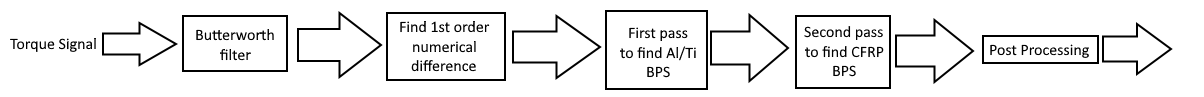

#### Filtering

The signal is processing using a Butterworth filter to remove high freq noise and try and remove false positives. This is still useful for Setitec signals as there are still high freq parts included.

Before entering Titanium the drill pulls back slightly causing a sharp dip in the signal. As this would be identified as a breakpoint is has to be removed. Luckily in the Setitec program metadata, it is assigned a Step code meaning it has a unique program assigned to do this and can be easily identified. The functions maskProgramStep and maskProgramStepIndex are used to find and replace where this occurs. It finds where the specified step code (either by code or index respectively) and over a specific period specified by the user replaces the data by interpolating between the first and last values created a flat period.

#### Numerical Difference
The numerical difference is used to find the breakpoint. This is NOT the gradient as it just finds the difference between neighbouring samples (see (np.diff)[https://numpy.org/doc/stable/reference/generated/numpy.diff.html] for more details). This contains similar information to the gradient, was just faster to implement and didn't require doing the rolling gradient which would introduce a delay. Can still be converted to gradient if needed though by just applying np.diff to the position array and dividing the torque difference by this.

#### Finding breakpoints
Identifying breakpoints uses a two pass approach. The first pass identifies the breakpoints for the second material. As this tends to be much harder than the first material, the change in torque is much more aggressive than the entry into the first material. From the point of view of the breakpoint algorithm, these changes are more attractive as breakpoints so assigning a high number of breakpoints would just apply more breakpoints over this area and not include the CFRP entry at the start. In the second pass, the signal is clipped from the start of the signal to the first breakpoint found in the first pass. This removes the influence of the second material and means it can search for the CFRP entry properly.

Below is an example of the current progress

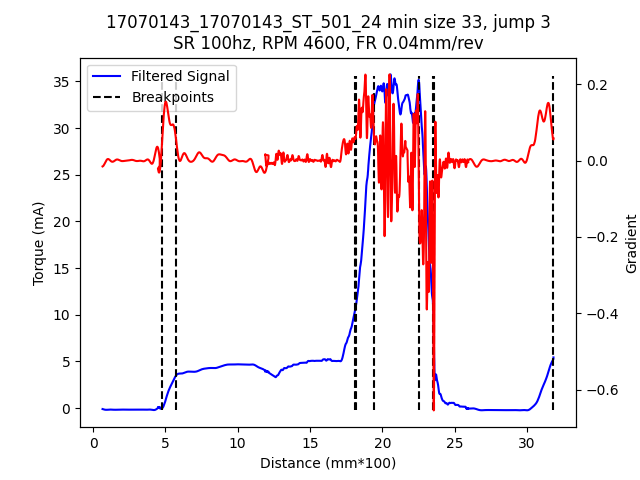

The blue signal is the torque and the red signal is the numerical difference. Extra breakpoints are added to account for the dynamics at the end of the signal.

#### Post Processing

Due to the two pass method, some of the breakpoints can be next to each other. The function filterBPSDropDist checks how far the breakpoints are from each other and replaces breakpoints within a certain distance of eachother with the mean of the two. A value of 2/10 mm tends to perform well.

## Issues

An ongoing issue is making sure the breakpoints are at the start end and of the template. Sometimes the breakpoints start part way up the slope instead of at the start. The following plot is a zoomed in region of the previous figure and shows that the first breakpoint for the entry into Titanium is starting partway up the slope.

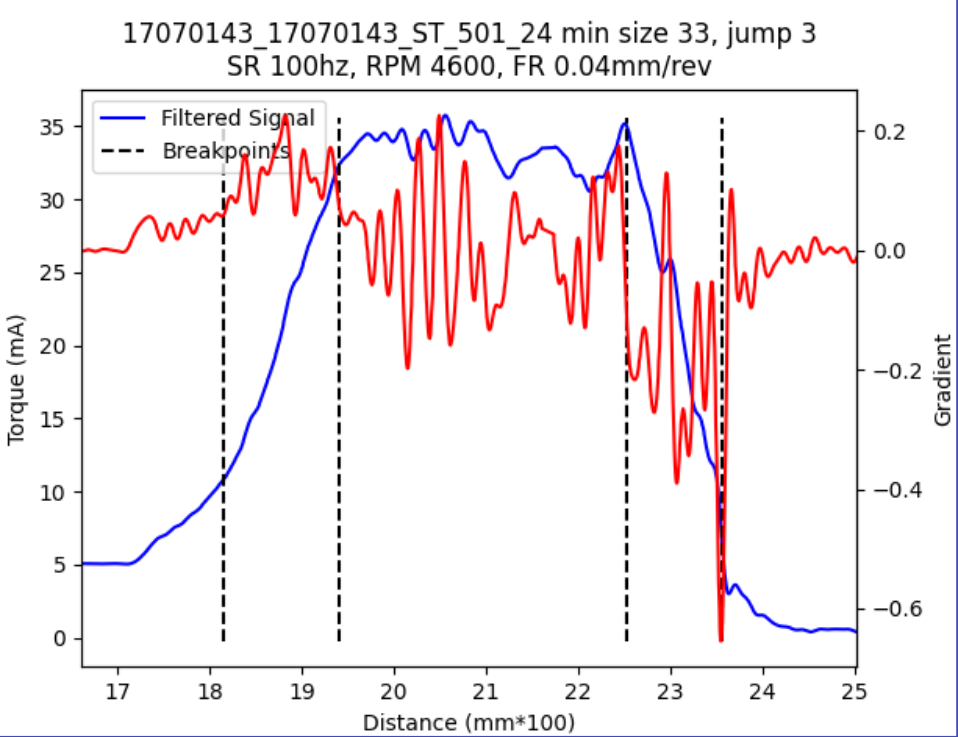

Some possible solutions
- For each breakpoint, search for a nearby location with a lower numerical gradient (Newton's method kind of thing)
- Update cost function used to better inform decisions. Ruptures has a page on [Combining cost functions](https://centre-borelli.github.io/ruptures-docs/examples/merging-cost-functions/). Not sure which cost models to combine though.
- Use a different cost function. Ruptures supports a wide range of cost models

In [3]:
# these imports are from the src folder of the main repo
from dataparser import loadSetitecXls
from find_opt_smoothing import filterButter, ToolShapelet, distToSamples, raise_sr

import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ruptures as rpt
from glob import glob

## Functions

This following section is the main functions used for template extraction. They should be documented, if not contacted developer.

In [4]:
def maskProgramStep(df,step,window=4.0):
    '''
        Find and mask where the specified programming step ends and replace the data

        The data is replaced by a fitted line connecting the first and last values in the range

        The window period is specified in mm by window parameter. The final positon of the target program
        step is the centre of the window and half the window size is used either side (i.e. pos +/- window/2).
        That period is replaced.

        The specified step is the step ID.

        Inputs:
            df : Setitec path string or already loaded dataframe
            step : Target step.
            window : Masking period in mm. Default 4.0 mm.

        Returns dataframe with replaced data
    '''
    if step<1:
        raise ValueError("Step code has to be +ve!")
    if isinstance(df,str):
        df = loadSetitecXls(df)[-1]
    if not (step in df['Step (nb)'].unique()):
        raise ValueError("Target step does not exist in the target file!")

    # find where step ends
    pos_min = df[df['Step (nb)']==step]['Position (mm)'].min()
    # mask either side
    mask = df[(df['Position (mm)']>=(pos_min-(window/2))) & (df['Position (mm)']<=(pos_min+(window/2)))].index

    #min_tq = df.iloc[mask]['I Torque (A)'].min()
    min_tq = df.iloc[mask[-1]]['I Torque (A)']
    #max_tq = df.iloc[mask]['I Torque (A)'].max()
    max_tq = df.iloc[mask[0]]['I Torque (A)']
    min_pos = df.iloc[mask]['Position (mm)'].min()
    max_pos = df.iloc[mask]['Position (mm)'].max()

    # fit line between start and end point
    #coefs = np.polyfit([max_pos,min_pos],[min_tq,max_tq],1)
    coefs = np.polyfit([abs(min_pos),abs(max_pos)],[min_tq,max_tq],1)

    # replace data with interpolation
    #pos = np.linspace(max_pos,min_pos,len(mask))
    pos = np.abs(df.iloc[mask]['Position (mm)'])
    tq_rep = np.poly1d(coefs)(pos)
    #df.loc[mask,'Position (mm)']=pos
    df.loc[mask,'I Torque (A)']=tq_rep
    
    return df

def maskProgramStepIndex(df,stepIndex,window=4.0):
    '''
        Same as maskProgramStep but you specify which step by index rather than by ID.

        e.g. if the step ids are 1,2,3 and user specifies 1 when the step ID 2 is replaced.

        Inputs:
            df : Setitec path string or already loaded dataframe
            stepIndex : Target step index.
            window : Masking period in mm. Default 4.0 mm.
    '''
    if isinstance(df,str):
        df = loadSetitecXls(df)[-1]
    return maskProgramStep(df,df['Step (nb)'].unique()[stepIndex],window)

def findPlotBpsCalcMinSize(torque_path:str,shapelet:ToolShapelet,**kwargs):
    '''
        Finds and plots the breakpoints in the signal by calculating the min_size and jump using tool
        geometry and process parameters.

        The ToolShapelet instance is used to convert the segments from millimetres to number of samples.

        The min distance between breakpoints is calculated by processing the segments into a single value.
        By default the smallest segment is selected but the user can provide a different method via select_min_dist.
        
        The spacing between breakpoints on the grid is set by the parameter jump. The spacing is converted from
        distance in mm to number of samples using the paramters feed_rate, rpm and sr. The user controls this
        parameter kind of like how much wiggle room they want for possible breakpoints.

        SAME AS MAIN VERSION BUT HAS maskProgramStep TO REMOVE PULLBACK

        Inputs:
            torque_path : Path to torque file
            shapelet : Instance of ToolShapelet describing the tool used in the signal
            feed_rate : Advance rate used in mm/rev. Default 0.04
            rpm : Angular velocity for file in rpm. Default 4500 rpm.
            sr : Sampling rate of the file in Hz. Default 100.
            jump : Spacing between the breakpoints to be evaluated in mm. Default 0.1 mm
            select_min_dist : Function for selecting the min size from the tool segments. Default min.
            model : Cost model or kernel model. See supported models for set bps_method. Default l2.
            bps_method : Breakpoint method. Default Dynp.
            fc : Nyquist cutoff frequency for Butterworth filter. Default 0.2.
            order : Model order of the Butterworth filter. Default 8.
            upsample : Upsample the signal to a new sampling rate. Default True.
            new_sr : New sampling rate to upsample to. Default 100 Hz.
            mask_th : Masking window size to remove backtracking. Default 4.0mm
            plot_grad : Plot the gradient. Default True.
            return_pos : Flag to return breakpoints as position rather than index. Default True.
            bps_th : Min distance threshold for removing neighbouring breakpoints. Default 0.5 mm

        Returns figure and found breakpoints
    '''
    import ruptures as rpt
    ## get parameters
    fr = kwargs.get("feed_rate",0.04)
    rpm = kwargs.get("rpm",4600)
    sr = kwargs.get("sample_rate",100)
    jump = kwargs.get("jump",0.1)
    mask_th = kwargs.get("mask_th",1.0)

    all_bkps = []
    # convert jump to number of samples
    jump_samples = distToSamples(jump,fr,rpm,sr)
    #print("jump (samples)",jump_samples)
    ## find min distance between points in terms of samples
    # get function for determining the best width
    select_min_dist = kwargs.get("select_min_dist",min)
    min_sz_samples = select_min_dist(shapelet.convertSegToSamples(fr,rpm,sr)[0])
    #print("min size (samples)",min_sz_samples)
    # get type of BPS method
    bps_method = kwargs.get("bps_method",rpt.Dynp)
    bps = bps_method(kwargs.get("model","l2"),min_sz_samples,jump_samples)
    # load torque file
    fname = os.path.splitext(os.path.basename(torque_path))[0]
    # load data
    #print("loading file")
    # try loading as a setitec file
    is_setitec = True
    df = loadSetitecXls(torque_path)[-1]
    # filter
    df = maskProgramStepIndex(df,1,mask_th)
    # if none of the columns contain the phrase Position then it's a Lueberring file
    # Lueberring has no header
    if not any(['Position' in c for c in df.columns]):
        is_setitec = False
        df = pd.read_excel(torque_path)
        unfiltered = df.torque.values
        dist = df.distance.values
    else:
        unfiltered = df['I Torque (A)'].values
        dist = np.abs(df['Position (mm)'].values)

    unf_min = unfiltered.min()
    unf_max = unfiltered.max()
    # filter the data
    #print("butter filter")
    filtered = filterButter(unfiltered,kwargs.get("fc",0.1),kwargs.get("order",10))
    # upsample if the flag is set to True and the new sampling rate does not equal the source
    if kwargs.get("upsample",True) and (sr != kwargs.get("new_sr",100)):
        #print("upsampling")
        # raise sampling rate
        filtered = raise_sr(filtered,sr,new_sr=kwargs.get("new_sr",100),smoothing=0.5)
        dist = raise_sr(dist,sr,new_sr=kwargs.get("new_sr",100),smoothing=0.5)
    ## fit and predict breakpoints
    # use numerical difference
    if kwargs.get("use_diff",True):
        #print("finding BPS using difference")
        diff = np.diff(filtered)
        #diff = filterButter(diff,kwargs.get("fc",0.01),kwargs.get("order",10))
        my_bkps = np.array(bps.fit_predict(diff,n_bkps=kwargs.get("bkps",5)))-1
    else:
        #print("finding BPS using signal")
        my_bkps = np.array(bps.fit_predict(filtered,n_bkps=kwargs.get("bkps",5)))-1

    ## plot the results
    f,ax = plt.subplots()
    # plot the original signal
    ax.plot(dist,filtered,'b-',label="Filtered Signal")
    if kwargs.get("plot_grad",False):
        tax = ax.twinx()
        tax.plot(dist[:-1],diff,'r-')
        tax.set(ylabel="Gradient")
    # plot the breakpoints
    #ax.vlines(dist[my_bkps],unf_min,unf_max,colors='k',linestyles='dashed',label="Breakpoints")
    all_bkps += my_bkps.tolist()
    ## find CFRP breakpoints
    # only done if a Setitec file
    # Lueberring files don't seem to have a CFRP entry step
    if is_setitec:
        cfrp = filtered[0:my_bkps[0]]
        cfrp_dist = dist[0:my_bkps[0]]
        # fit and predict breakpoints
        bps = bps_method(kwargs.get("model","l2"),min_sz_samples,jump_samples)
        if kwargs.get("use_diff",True):
            #print("finding CFRP BPS using difference")
            cfrp_diff = np.diff(cfrp)
            #cfrp_diff = filterButter(cfrp_diff,kwargs.get("fc",0.01),kwargs.get("order",10))
            my_bkps = np.array(bps.fit_predict(cfrp_diff,n_bkps=kwargs.get("cfrp_nbkps",2)))-1
        else:
            #print("finding CFRP BPS using signal")
            my_bkps = np.array(bps.fit_predict(cfrp,n_bkps=kwargs.get("cfrp_nbkps",2)))-1

        all_bkps += my_bkps.tolist()
        # final plotting
        #ax.vlines(dist[my_bkps],unf_min,unf_max,colors='g',linestyles='dotted',label="CFRP Breakpoints")
    else:
        print("Skipping finding CFRP breakpoints as file is Lueberring!")
    # sort in ascending order
    all_idx = all_bkps
    all_bkps = np.sort(dist[all_bkps])
    # filter to remove neighbouring breakpoints
    all_bkps = filterBPSDropDist(all_bkps,th=kwargs.get("bps_th",0.2))

    all_bkps = dist[pullbackBP(diff,all_idx)]
    # find the indicies again after correction
    all_new_idx = [np.argmin(np.abs(dist-b)) for b in all_bkps]
    print("bkps grad",diff[all_new_idx])
    all_grad = diff[all_new_idx]
    # draw vertical lines where breakpoiints are
    ax.vlines(all_bkps,unf_min,unf_max,colors='k',linestyles='dashed',label="Breakpoints")
    ax.legend()
    ax.set(xlabel="Distance (mm*100)",ylabel="Torque (mA)",title=f"{fname} min size {min_sz_samples}, jump {jump_samples}\nSR {sr}hz, RPM {rpm}, FR {fr}mm/rev")
    if kwargs.get("return_pos",True):
        return f,all_bkps
    else:
        return f,all_idx
    
def filterBPSDropDist(bps,th=0.1):
    '''
        Filter breakpoints to only those a certain distance from each other

        Due to the method of finding breakpoints, they can often overlap or be very close to each other (within 1 sample).
        However, due to the sampling rate and process parameters a distance of 1 sample can be valid so the breakpoints need to be
        filtered based on physical distance.

        If two breakpoints are within th mm of each other, they are replaced by the mean of the two breakpoints

        Inputs:
            bps : Breakpoints in mm
            th : Min required distance in mm. Default 0.1mm.

        Returns list of filtered breakpoints
    '''
    # check threshold
    if th<=0:
        raise ValueError("BPS distance threshold cannot be <=0!")
    # ensure it's an array
    bps = np.array(bps)
    # make list to hold new bps
    new_bps = []
    # check if any of the breakpoints are within the threshold of each other
    if np.any(np.diff(bps)<th):
        # iterate over breakpoints in pairs
        for a,b in zip(bps[::2],bps[1::2]):
            # if they are within th mm of each other
            if abs(a-b)<th:
                new_bps.append(np.mean([a,b]))
            # add pair to list
            else:
                new_bps.extend([a,b])
        # iteration stops just before last BP
        # add onto the end
        new_bps.append(bps[-1])
    return new_bps

def pullbackBP(tq: (np.ndarray, list),bps_idx:(np.ndarray, list),th:float=1e-8,maxits:int=1000)->list:
    '''
        A bad attempt at iteratively moving breakpoints back to where the numerical difference is below a threshold
    
        Inputs:
            tq : Array of torque values
            bps_indx : Breakpoints in terms of data index
            th : Numerical difference threshold to aim for. Default 1e-8
            maxits : Max number of iterations to avoid long compute times. Default 1000.
        
        Returns list of updated breakpoints
    '''
    # list of corrected breakpoints
    new_bps = []
    # number of indicies
    nbps = len(tq)
    # iterate over each bp
    for bi in bps_idx:
        its=0
        # store starting index
        start_idx=bi
        # set current index
        current_idx=bi
        # set direction to moving to the left
        direction = -1
        # whilst current index doesn't go out of bounds
        while (current_idx >=0) and (current_idx < (nbps-1)) and (its<maxits):
            # set past location to current
            past_idx = bi
            # move index in direction
            current_idx = bi+direction
            # find different in height
            diff_height = tq[current_idx] - tq[past_idx]
            # if already close to zero
            if diff_height<=th:
                break
            # if the height is increasing
            # change direction
            elif diff_height>0:
                direction *= -1
            its+=1
        if its==maxits:
            print("reached iteration limit! Not changing new bp")
            new_bps.append(start_idx)
        else:
            print(f"setting new breakpoint to {current_idx} vs {start_idx}")
            new_bps.append(current_idx)
        #new_bps.append(start_idx if its==maxits else current_idx)
    return new_bps

## Code Example

In [2]:
# shapelet defining the tool used
# currently a dummy one
# used to set the min_size for breakpoint calculations
# feel free to replace with actual values
ts = ToolShapelet([1,2,3],[1,2,3])

for fn in glob("*.xls"):
    # finds and plots the breakpoints on the signal
    # plot_grad is for controlling whether to plot the numerical difference
    # return_pos controls whether the returned gradient is in terms of pos (mm) or data index (mm)
    f,bps = findPlotBpsCalcMinSize(fn,ts,return_pos=False,plot_grad=True)
    # load file to get torque values
    df = loadSetitecXls(fn)[-1]
    tq = df['I Torque (A)'].values
    new_bps = pullbackBP(tq,bps,1e-8,1000)


NameError: name 'ToolShapelet' is not defined